In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import sys
from importlib import import_module

sys.path.append('../')
analytics = import_module('explore.analytics')
t_funcs = import_module('python_scripts.timeSeriesFunctions')
p_func = import_module('prediction_models.genericRegressionClassification')

In [2]:

# Set a start date
start_date = datetime(2023, 1, 1)

# Create an hourly timestamp index for 2400 data points
timestamps = [start_date + timedelta(hours=i) for i in range(2400)]

# Create sinusoidal changes for temperature and humidity with added noise
hours = np.array([i.hour for i in timestamps])  # Convert to NumPy array
temperature_amplitude = 5  # Amplitude of the temperature sine wave
humidity_amplitude = 10  # Amplitude of the humidity sine wave
temperature_offset = 6  # Temperature sine wave offset in hours
humidity_offset = 9  # Humidity sine wave offset in hours
noise_std_dev = 1.5  # Standard deviation of the noise

# Create sinusoidal data with noise
temperature = (
    25 + temperature_amplitude * np.sin(2 * np.pi * (hours - temperature_offset) / 24) +
    np.random.normal(scale=noise_std_dev, size=len(timestamps))
)

humidity = (
    55 + humidity_amplitude * np.sin(2 * np.pi * (hours - humidity_offset) / 24) +
    np.random.normal(scale=noise_std_dev, size=len(timestamps))
)

temperature = t_funcs.create_anomaly(temperature,20)
humidity = t_funcs.create_anomaly(humidity,20)

# Create a DataFrame
data = {'Timestamp': timestamps, 'temperature': temperature, 'humidity': humidity}
df = pd.DataFrame(data)

# Set the timestamp as the index
df.set_index('Timestamp', inplace=True)

# Display the first few rows of the generated data
print(df.head())


                     temperature   humidity
Timestamp                                  
2023-01-01 00:00:00    19.936042  46.816025
2023-01-01 01:00:00    19.556169  45.744149
2023-01-01 02:00:00    19.404633  44.581987
2023-01-01 03:00:00    21.165193  44.125536
2023-01-01 04:00:00    20.623537  45.139021


<Axes: xlabel='Timestamp'>

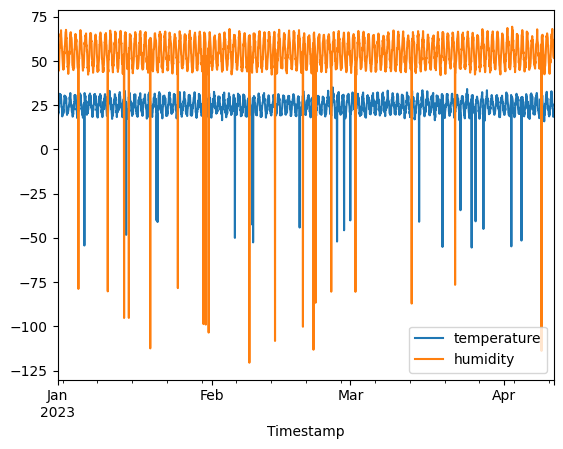

In [3]:
df.plot()

In [4]:
window_size=24
stride=1
num_features=len(df.columns)

In [5]:
df_normalized,df_mean,df_std = t_funcs.z_score_normalize(df)
X_window,y_window = t_funcs.create_windows(df_normalized.to_numpy(),window_size=window_size, stride=stride)

In [6]:
X_batched = np.concatenate([np.array([s]) for s in X_window],axis=0)
y_batched = np.concatenate([np.array([s]) for s in y_window],axis=0)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

In [8]:
# convert to pytorch tensor
X_batched_tensor = torch.tensor(X_batched,dtype=torch.float32).view(-1,window_size,num_features)
y_batched_tensor = torch.tensor(y_batched,dtype=torch.float32).view(-1,num_features)

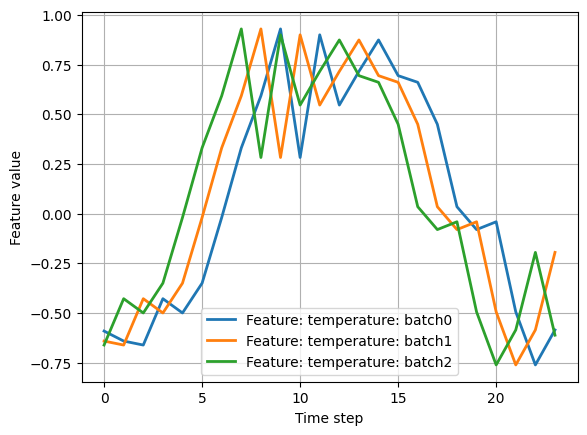

In [9]:
import matplotlib.pyplot as plt

X_batched_numpy = X_batched_tensor.cpu().numpy()

temperature_series_0 = X_batched_numpy[0,:,0]
temperature_series_1 = X_batched_numpy[1,:,0]
temperature_series_2 = X_batched_numpy[2,:,0]

plt.figure()
plt.plot(temperature_series_0,label='Feature: temperature: batch0',linewidth=2)
plt.plot(temperature_series_1,label='Feature: temperature: batch1',linewidth=2)
plt.plot(temperature_series_2,label='Feature: temperature: batch2',linewidth=2)
plt.xlabel('Time step')
plt.ylabel('Feature value')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
train_size = int(0.8 * len(X_batched_tensor))
val_size = len(X_batched_tensor) - train_size

X_train = X_batched_tensor[:train_size]
y_train = y_batched_tensor[:train_size]

X_val = X_batched_tensor[train_size:]
y_val = y_batched_tensor[train_size:]

In [11]:

train_dataset = p_func.TensorDataset(X_train,y_train)
test_dataset = p_func.TensorDataset(X_val,y_val)

In [14]:
batch_size=20
train_loader = p_func.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
val_loader = p_func.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)

In [15]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout ,*args, **kwargs):
        super(LSTMModel).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim,output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        
        # Index hidden state of last time step
        out = self.fc(out[:, -1, :])
        return out
    
input_dim = num_features
output_dim = num_features
hidden_dim = 4
num_layers = 2
dropout = 0.2


In [ ]:
model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers, dropout)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=1e-1, weight_decay=1e-8)